<a href="https://colab.research.google.com/github/fabriziobasso/kaggle/blob/main/ARNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modern Time Series Forecasting: For Predictive Analytics and Anomaly Detection
[Link](https://github.com/dataman-git/codes_for_articles/blob/master/02.2_neuralprophet_bike_share_AR_lagged.ipynb) - Github

[Link](https://medium.com/@dataman-ai/neuralprophet-i-trend-seasonality-holidays-31df8ef30357) - Medium


In the previous chapter “NeuralProphet (I) — Trend + Seasonality + Holidays”, we show how to build a time series forecasting model with NeuralProphet. We have covered the trend, the seasonality, and the holidays and events components. If you were trained by the ARIMA (Auto-Regressive Integration Moving-Average) school, you may find the GAM framework of Prophet does not explicitly specify the auto-regressive (AR) terms. Prophet uses the trend and seasonal terms to capture what could be captured by the AR terms to some extent. Nevertheless, it would be beneficial to explicitly specify AR terms to increase its predictability.

In this chapter, you will learn the neural network framework called AR-Net. You will learn how to model with AR-Net in NeuralProphet. You will also learn how to use the lagged regressors module and the future regressors module. This chapter will build more models by adding new modules to predict the bike-rental time series. We will be able to select the best model among the the models. Finally, this chapter will use the best model to provide multi-step-ahead forecasts. The topics are:

1. Understanding the classic AR models
2. The Neural Network for AR — The AR-Net
3. The AR module of NeuralProphet
4. Trend + Seasonality + Holidays + AR
5. AR with hidden layers
6. Trend + Seasonality + Holidays + AR + Lagged regressors
7. Trend + Seasonality + Holidays + AR + Lagged regressors + Future regressors • Model comparison and selection
8. Forecasting future periods


### 1.0 Understanding the classical AR models

An autoregressive (AR) model uses past values of a variable to predict its future values. It assumes that the current value of a variable is a linear combination of its past values plus an error term. The number of past values in an autoregressive model is called the model of order. An autoregressive model of order p is denoted as AR(p) and expressed as:

![ar_fig1.png](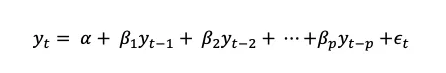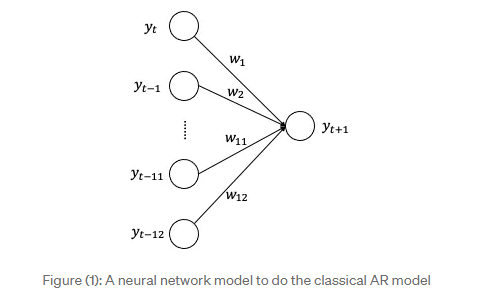)

Here yt is the value of the time series at time t, yt-1, …, yt-p are the past values, beta_1 — beta_p are the autoregressive coefficients, alpha is a constant term, and epsilon is the white noise error term at time t.

The coefficients determine the strength and direction of the relationship between the current value and its past values. The following AR(2) model is an example showing the prediction for yt is 0.8 times yt-1 minus 0.2 times yt-2 plus the constant 0.6. This linear regression style is simple, letting users to do elementary school addition. The model is interpretable because it is not a black box and it can win the trust of users to follow its model predictions for actions.

### The Neural Network for AR — The AR-Net

An AR model with just a few past terms (low p-order) is easily interpretable. However, in many time series remote terms still influence the current term, which means the above AR equation shall have many past terms (high p-order). When there are many terms in the right hand side of the equation, there could even be interactions between those past terms. The linear assumption becomes too restrictive. A deep-learning framework may be a better choice to capture the complex non-linear interactions of all the past terms. In past two decades, the time-series community has developed various deep-learning frameworks such as LSTM (Long Short-Term Memory), Recurrent Neural Networks (RNN), and Convolutional Neural Networks (CNN) to better describe the long-term dependencies.

Triebe, Laptev & Rajagopal (2019) propose a feed-forward neural network approach, AR-Net, to capture the dynamics in the AR terms. Figure (1) illustrates the basic form of AR-Net. It has the input layer for the past terms and the output layer for the target term Yt+1. The target term is a linear combination of the past terms with different weights. Triebe, Laptev & Rajagopal show that the AR-Net model in its basic form can be as interpretable as the classic AR models, and in some cases delivers the same parameters. The AR-Net can scale to high p-orders to estimate long-term dependencies.


Figure (1): A neural network model to do the classical AR model
In many time series forecasting, we are interested in predicting multiple future steps. The neural-network framework of AR-Net enables it to produce multi-step forecasts. Figure (2) shows the output layer can have multiple future terms, enabling multi-period forecasts. This is a great advantage over the classic AR models, as shown in the above questions, that produce one-step-ahead estimates.

In many time series forecasting, we are interested in predicting multiple future steps. The neural-network framework of AR-Net enables it to produce multi-step forecasts. Figure (2) shows the output layer can have multiple future terms, enabling multi-period forecasts. This is a great advantage over the classic AR models, as shown in the above questions, that produce one-step-ahead estimates.


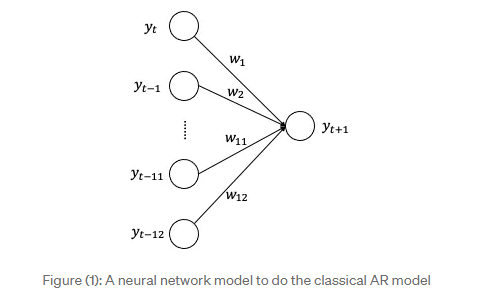

##The AR module of NeuralProphet##

Let’s learn the AR module itself by turn off the change point detection and the seasonality. This will result in an AR model plus a straight linear trend. We set a high order such as n_lags=10 for the model. This does
not mean all the 10 past terms will be statistically significant. As said before, the automatic determination of the order p terms makes it unnecessary
 to pre-specify the true order of the AR process.

In [2]:
%%capture
!pip install neuralprophet
!pip install -U kaleido

# neuralprophet does not work with colab unless numpy1.23.5: https://github.com/googlecolab/colabtools/issues/3752
#!pip uninstall numpy
#!pip install git+https://github.com/ourownstory/neural_prophet.git numpy==1.23.5

In [3]:
from neuralprophet import set_random_seed
set_random_seed(0)

ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.
ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.


In [6]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import logging
import warnings
logging.getLogger('prophet').setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [13]:
%%time

# Setting rc parameters in seaborn for plots and graphs-
# Reference - https://matplotlib.org/stable/tutorials/introductory/customizing.html:-
# To alter this, refer to matplotlib.rcParams.keys()

sns.set({"axes.facecolor"       : "#ffffff",
         "figure.facecolor"     : "#ffffff",
         "axes.edgecolor"       : "#000000",
         "grid.color"           : "#ffffff",
         "font.family"          : ['Cambria'],
         "axes.labelcolor"      : "#000000",
         "xtick.color"          : "#000000",
         "ytick.color"          : "#000000",
         "grid.linewidth"       : 0.75,
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : '#0099e6',
         'axes.titlesize'       : 8.5,
         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,
        });

# Making sklearn pipeline outputs as dataframe:-
pd.set_option('display.max_columns', 100);
pd.set_option('display.max_rows', 50);

sns.set_style("whitegrid",{"grid.linestyle":"--", 'grid.linewidth':0.2, 'grid.alpha':0.5})
#sns.set_theme(style="ticks", context="notebook")
sns.despine(left=True, bottom=True, top=False, right=False)

mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

CPU times: user 1.95 ms, sys: 0 ns, total: 1.95 ms
Wall time: 1.94 ms


<Figure size 640x480 with 0 Axes>

In [14]:
%%capture
# Connect to Colab:
from google.colab import drive
drive.mount('/content/drive')

In [15]:
folder_script = models_folders = "/content/drive/MyDrive/Exercises/Time_Series_Studies/Scripts/Modern Time Series - Book/Chapter 3: NeuralProhet/"
os.chdir(folder_script)

In [16]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import logging
import warnings
logging.getLogger('prophet').setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

### 1.0 Data preparation

Let’s talk about the data for our modeling exercise. I used the Bike Share Daily data from Kaggle (here or here) as used in Chapter 2: Prophet for business forecasting. This dataset is a multivariate dataset for the rental demand for bicycles. It has other covariates like temperature or wind speed.

In [17]:
data = pd.read_csv('bike_sharing_daily.csv')
# convert string to datetime64
data["ds"] = pd.to_datetime(data["dteday"])
data.tail()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,ds
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114,2012-12-27
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095,2012-12-28
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341,2012-12-29
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796,2012-12-30
730,731,2012-12-31,1,1,12,0,1,1,2,0.215833,0.223487,0.577500,0.154846,439,2290,2729,2012-12-31


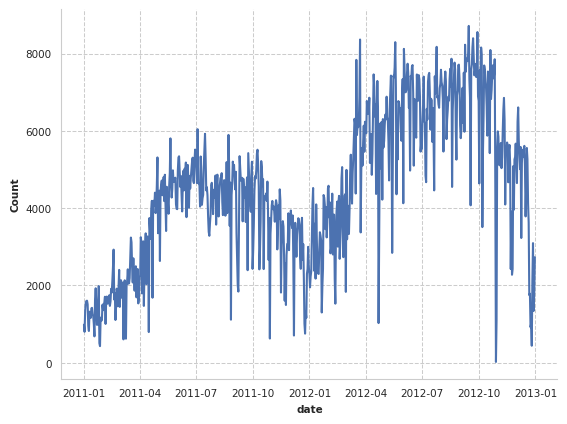

In [18]:
# create line plot of sales data
plt.plot(data['ds'], data["cnt"])
plt.xlabel("date")
plt.ylabel("Count")
plt.show()

We will do a very minimal data preparation for modeling. Same as Prophet, NeuralProphet requires the column names to be “ds” and “y”.

In [19]:
df = data[['ds','cnt']]
df.columns = ['ds','y']

Let’s build a simple NeuralProphet model with all the default parameters. The goal here is to orient ourselves with its basic code and output interface.

In [21]:
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level

# Model and prediction
m = NeuralProphet(
    n_changepoints=10,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
)
# Use static plotly in notebooks
m.set_plotting_backend("matplotlib")
metrics = m.fit(df)
forecast = m.predict(df)

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.863% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO:NP.df_utils:Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normaliz

Finding best initial lr:   0%|          | 0/222 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.863% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.863% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


Predicting: 23it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


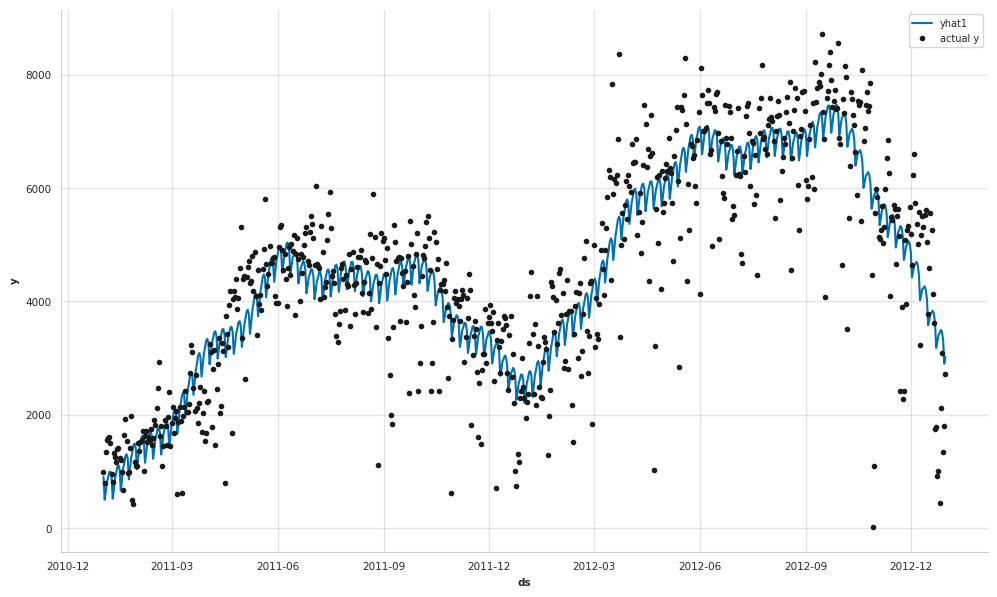

In [22]:
m.plot(forecast)

Once done, we will make a new data frame for the forecasts by using .make_future_dataframe(). NeuralProphet inherits this from Prophet.

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.863% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: 23it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


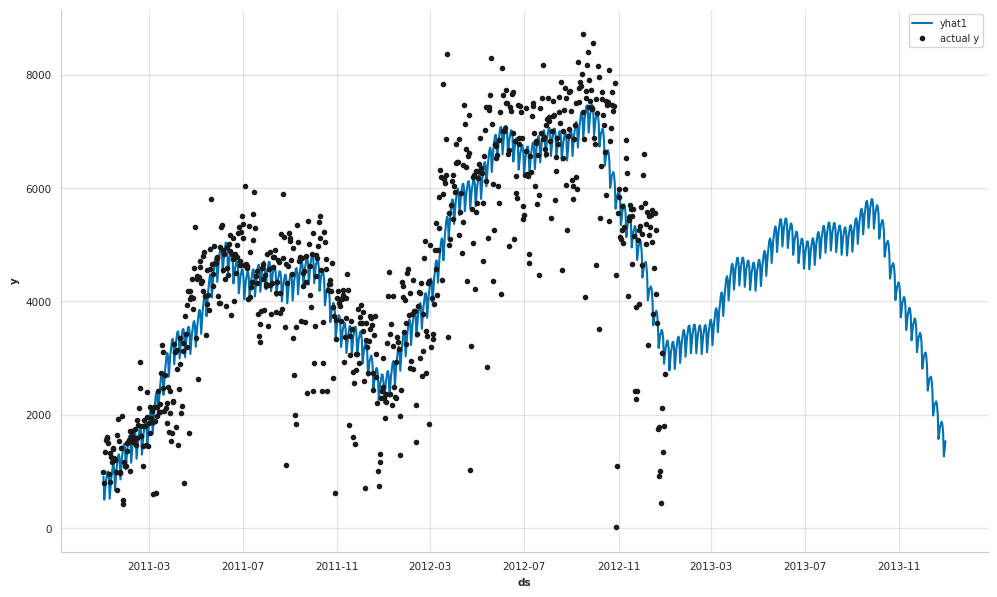

In [23]:
# Create a new dataframe reaching 365 into the future for our forecast, n_historic_predictions also shows historic data
df_future = m.make_future_dataframe(df,
              n_historic_predictions=True,
              periods=365)

# Predict the future
forecast = m.predict(df_future)

# Visualize the forecast
m.plot(forecast)